In [1]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow

**Daniel Moser (UT Southwestern Medical Center)**

**Resources: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import to_categorical

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [3]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

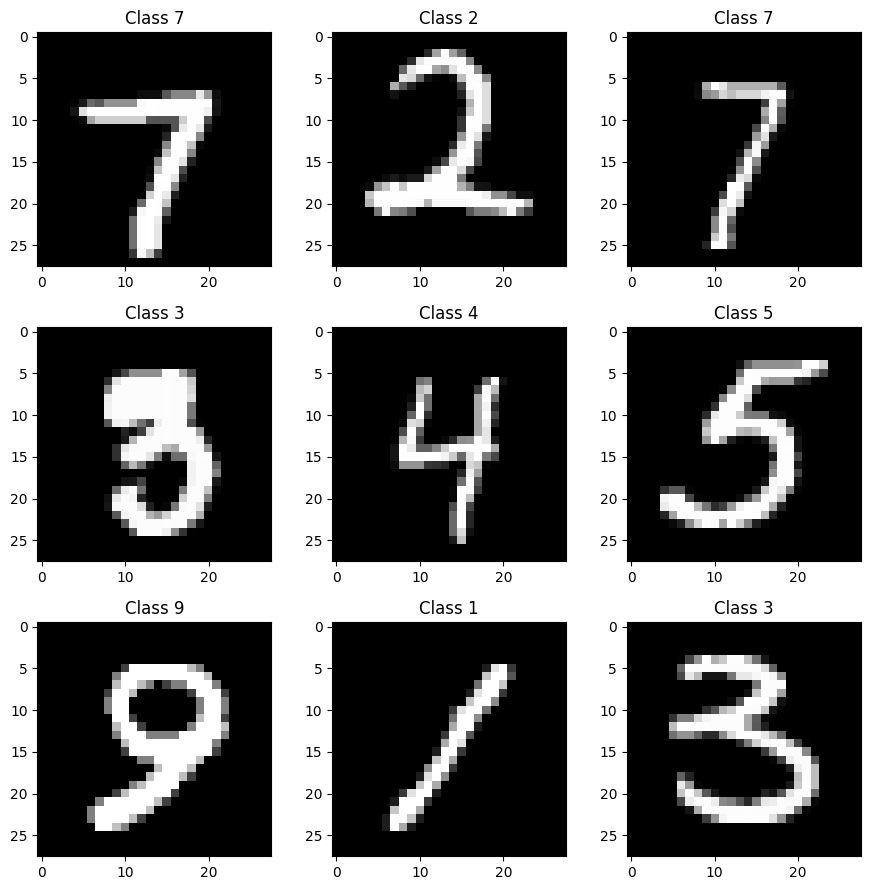

In [4]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [5]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
matprint(X_train[num])

0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    4   69  148  254  174  201  253  253  193  113   22    0    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0  101  252  252  253  252  252  252  252  253  252  221   99    0    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0   73  231  187   21   21   21  118  231  232  247  252  247  144    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    0    0    0    0    0    0    0  120  252  252  252    0    0    0    0  0  0  0  0  0  
0  0  0  0  0    0    0    0    

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

*Fun-fact! Your computer screen has three channels for each pixel: red, green, blue. Each of these channels also likely takes an 8-bit integer. 3 channels -- 24 bits total -- 16,777,216 possible colors!*

## Formatting the input data layer

Instead of a 28 x 28 matrix, we build our network to accept a 784-length vector.

Each image needs to be then reshaped (or flattened) into a vector. We'll also normalize the inputs to be in the range [0-1] rather than [0-255]. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [12]:
#X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
#X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28)
Testing matrix shape (10000, 28, 28)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [7]:
nb_classes = 10 # number of unique digits

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Building a 3-layer fully connected network (FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

## Compiling the model

Keras is built on top of Theano and TensorFlow. Both packages allow you to define a *computation graph* in Python, which then compiles and runs efficiently on the CPU or GPU without the overhead of the Python interpreter.

When compiing a model, Keras asks you to specify your **loss function** and your **optimizer**. The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

Our predictions are probability distributions across the ten different digits (e.g. "we're 80% confident this image is a 3, 10% sure it's an 8, 5% it's a 2, etc."), and the target is a probability distribution with 100% for the correct category, and 0 for everything else. The cross-entropy is a measure of how different your predicted distribution is from the target distribution. [More detail at Wikipedia](https://en.wikipedia.org/wiki/Cross_entropy)

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

## Train the model!
This is the fun part!

The batch size determines over how much data per step is used to compute the loss function, gradients, and back propagation. Large batch sizes allow the network to complete it's training faster; however, there are other factors beyond training speed to consider.

Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum.

Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum.

So a good batch size may take some trial and error to find!

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.7590 - loss: 0.8455 - val_accuracy: 0.9400 - val_loss: 0.2135
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9208 - loss: 0.2706 - val_accuracy: 0.9612 - val_loss: 0.1465
Epoch 3/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9412 - loss: 0.1999 - val_accuracy: 0.9695 - val_loss: 0.1171
Epoch 4/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9525 - loss: 0.1615 - val_accuracy: 0.9720 - val_loss: 0.1013
Epoch 5/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - accuracy: 0.9582 - loss: 0.1416 - val_accuracy: 0.9762 - val_loss: 0.0898
Epoch 6/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.9641 - loss: 0.1181 - val_accuracy: 0.9780 - val_loss: 0.0829
Epoch 7/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 40s 6ms/step - accuracy: 0.9693 - loss: 0.1019 - val_accuracy: 0.9767 - val_loss: 0.0800
Epoch 8/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9716 - loss: 0

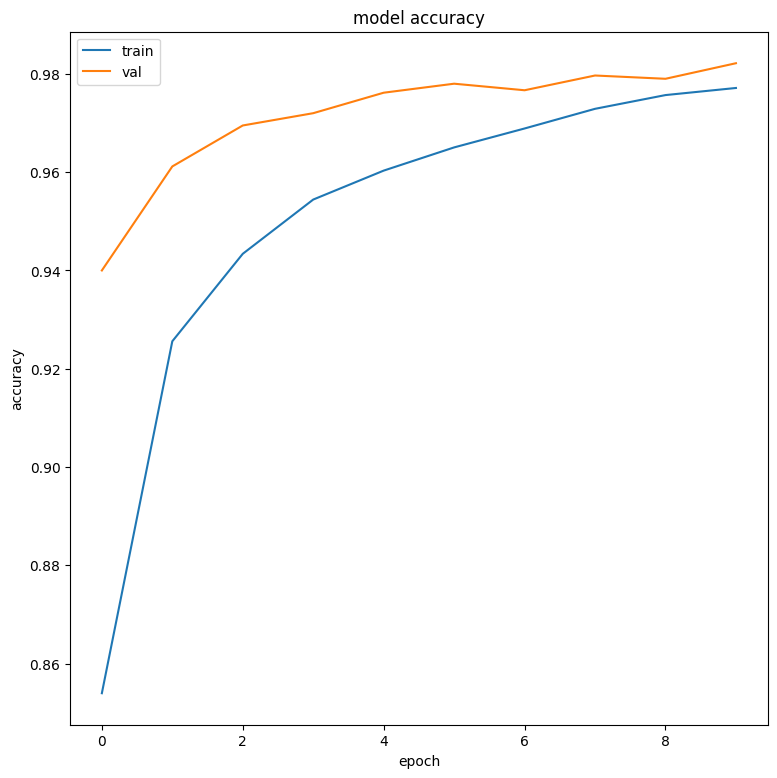

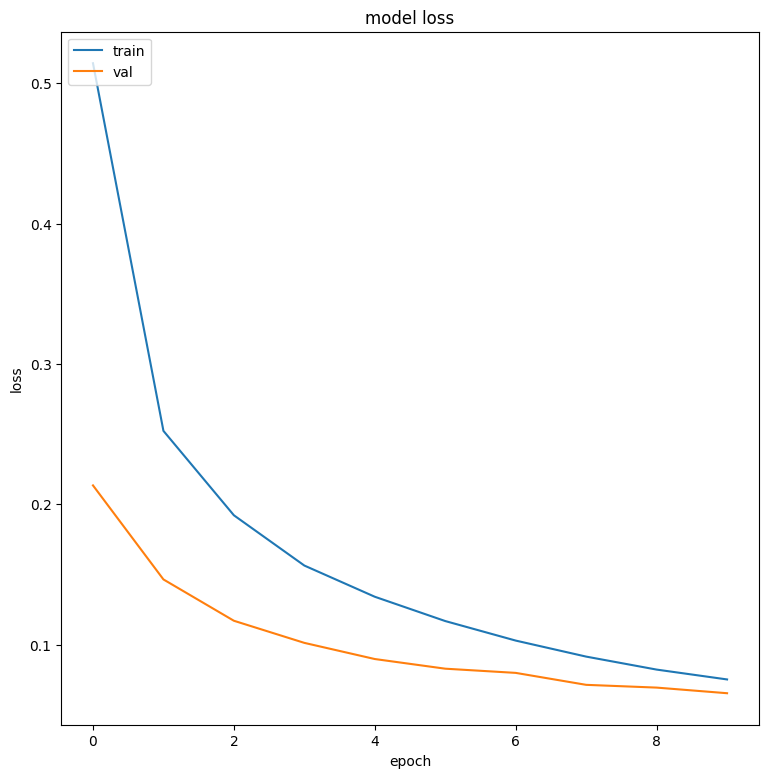

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,708 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [8]:
import keras

model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation="softmax")
    ])

model.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])


history = model.fit(X_train, Y_train,
          batch_size=16, epochs=10,
          validation_split=0.1,
          verbose=1)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

model.summary()

The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [9]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9728 - loss: 0.0865
Test score: 0.07397942245006561
Test accuracy: 0.977400004863739


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [10]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
# predicted_classes = model.predict_classes(X_test)

prediction_probs=model.predict(X_test)
predicted_classes=np.argmax(prediction_probs, axis=1)


# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


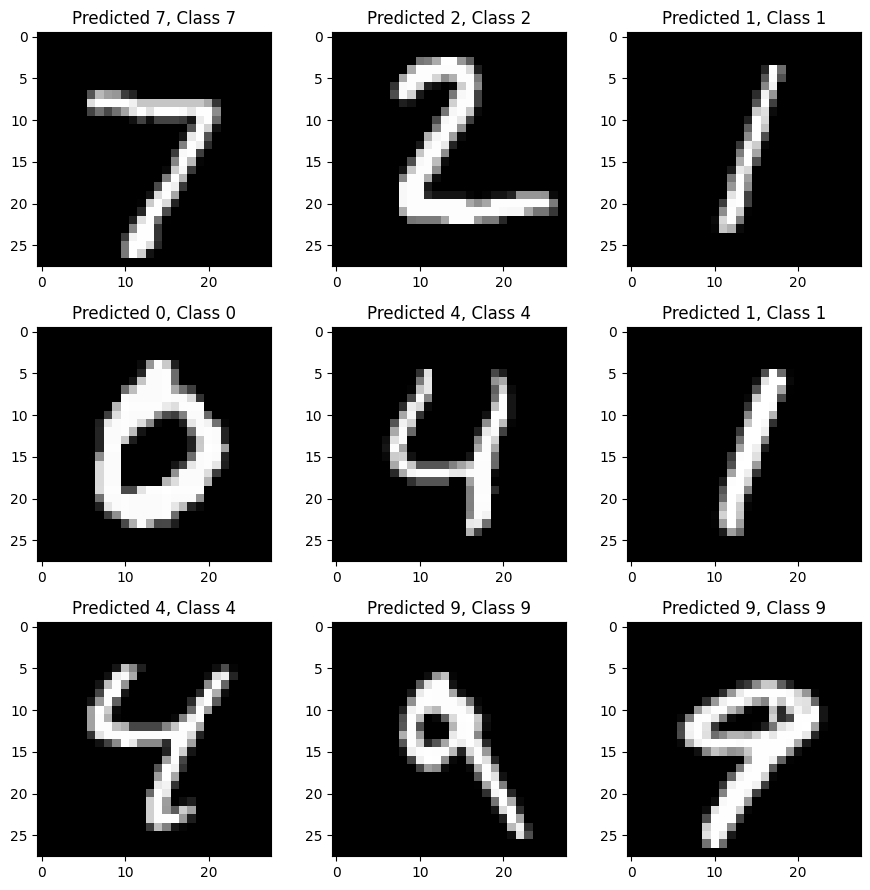

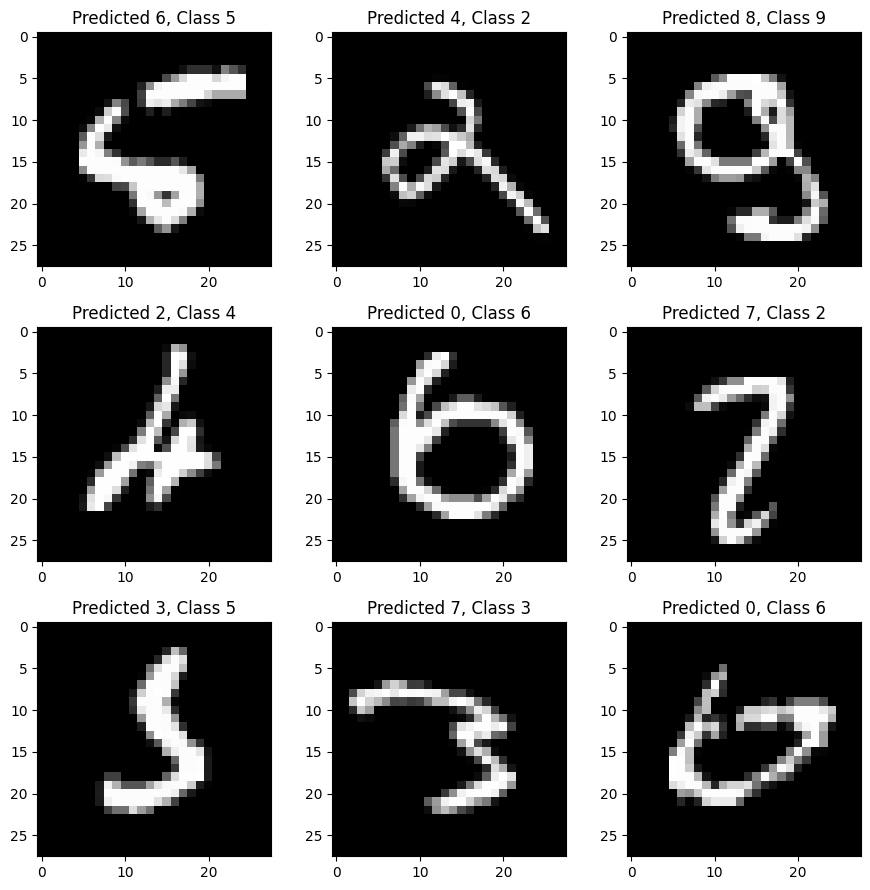

In [11]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.tight_layout()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

plt.tight_layout()

# Trying experimenting with the Optimizers!



1. Try 4 additional optimizers from https://keras.io/api/optimizers/, summarize the observed test accuracy for each optimizer you tried.
1. Which optimizer gave the best performance out of the box?
1. Pick two optimizers and experiment with 1 or 2 of the the available hyper-parameters, how much better were you able to get the test accuracy.  Summarize the optimizers and the hyper parameters along with the observed test accracy.

In [20]:
from keras.optimizers import SGD, Adam, Nadam, Adagrad, AdamW

def build_model(optimizer):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(28,28)),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

optimizers = {
    'Adam': Adam(),
    'Nadam': Nadam(),
    'Adagrad': Adagrad(),
    'AdamW': AdamW()
}

# dictionary to store the results of test accuracies
test_accuracies = {}

# train and evaluate model with each optimizer
for optimizer_name, optimizer in optimizers.items():
    model = build_model(optimizer)
    model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    test_accuracies[optimizer_name] = test_accuracy

In [21]:
test_accuracies

{'Adam': 0.9779999852180481,
 'Nadam': 0.9768999814987183,
 'Adagrad': 0.11349999904632568,
 'AdamW': 0.975600004196167}

Adagrad performance is very different comparing to the other optimizers. The potential reason could be the way it adjusts learning rates. Adagrad adapts the learning rate for each parameter based on the historical gradients, so the parameters with larger gradients will have their learning rate reduced more significantly over time. In our case it looks like the learning rate became very small, which hinders further learning and leads to very low accuracy.

I choose Adam and Nadam since they performed the best.


I chose the following hyperparameters for Adam :
- learning rate to control how big the steps are when updating the model’s parameters;
- beta 1 that defines how much of the past gradients influence the current step;
- beta 2 that controls how much of the squared gradients influence the update;


For Nadam:
- learning rate;
- weight decay that helps regularize the model by penalizing large weights, which can improve generalization;

In [23]:
# Adam optimizer experimentation
adam_optimizer_1 = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.999)
adam_optimizer_2 = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.99)

# Nadam optimizer
nadam_optimizer_1 = Nadam(learning_rate=0.001, weight_decay=0.0001)
nadam_optimizer_2 = Nadam(learning_rate=0.0005, weight_decay=0.0005)

optimizers = {
    'Adam_1': adam_optimizer_1,
    'Adam_2': adam_optimizer_2,
    'Nadam_1': nadam_optimizer_1,
    'Nadam_2': nadam_optimizer_2
}

test_accuracies = {}

for optimizer_name, optimizer in optimizers.items():
    model = build_model(optimizer)
    model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    test_accuracies[optimizer_name] = test_accuracy

In [24]:
test_accuracies

{'Adam_1': 0.9790999889373779,
 'Adam_2': 0.9739000201225281,
 'Nadam_1': 0.9778000116348267,
 'Nadam_2': 0.9718000292778015}